In [ ]:
# numpy random uses Mersenne Twist pseudorandom number genarator 
import requests
import numpy as np
import pandas as pd
import time
import string
from tqdm.notebook import tqdm
from scipy.integrate import quad as integrate
from scipy.stats import expon, pareto
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import gc
# Use to explicity free memory
# gc.collect()

## Monte Carlo to calculate $\sqrt 2$

In [ ]:
def curve(x):
    """
    Curve defined to find 2^(0.5)
    f(x) = 2 - x^2
    """
    return 2-x**2

In [ ]:
def g_x_y(x_list,y_list):
    """
    Indicator function g(X,Y)
    
    Parameters
    ----------
    x_list: list
        List of x values

    y_list: list
        List of y values

    Returns
    -------
    g_list: list
        List of indicator 
        function results

    """
    g_list = []
    for x,y in zip(x_list,y_list):
        if 2-x**2-y>=0:
            g_list.append(1)
        else:
            g_list.append(0)
    return g_list

In [ ]:
def mcmc_sim_sqrt(n_list, points=False):
    """
    Monte Carlo method to calculate
    sqrt(2) based on the area of 
    the curve 2-x^2 and the area 
    of square with side=2

    Parameters
    ----------
    n_list: list
        List with number of 
        samples to use

    Returns
    -------
    error_list: list
        List of error for each 
        number of samples

    points_dict: dict
        Contains points to be
        plotted
    """
    np.random.seed(1)
    error_list = []
    for n in n_list:
        x = np.random.uniform(high=2,size=n)
        y = np.random.uniform(high=2,size=n)
        # For plotting purpouses
        if points:
            points_dict = {'x':x, 'y':y}
        M_n = sum(g_x_y(x,y))/n
        e_hat = 3*M_n
        rel_error = abs(e_hat-np.sqrt(2))/np.sqrt(2)
        error_list.append(rel_error)
    if points:
        return error_list, points_dict
    return error_list


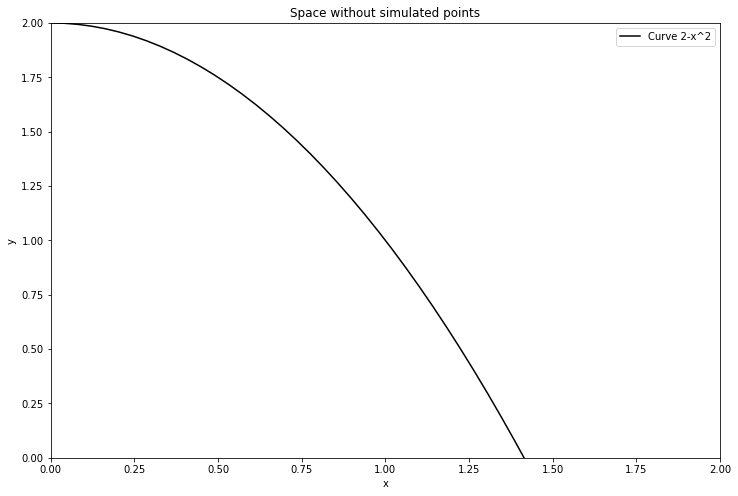

In [ ]:
plt.figure(figsize=(12,8))
plt.ylim(bottom=0, top=2)
plt.xlim(left=0, right=2)
plt.title("Space without simulated points")
plt.xlabel("x")
plt.ylabel("y")
x = np.linspace(0,2,50)
plt.plot(x,curve(x), 'k', label='Curve 2-x^2')
plt.legend()
plt.show()

In [ ]:
n_list = [10**6]
_,points_dict = mcmc_sim_sqrt(n_list,True)
points_dict['point_class'] = g_x_y(points_dict['x'],points_dict['y'])
points_df = pd.DataFrame(points_dict)
points_inside = points_df[points_df['point_class']==1]
points_outside = points_df[points_df['point_class']==0]

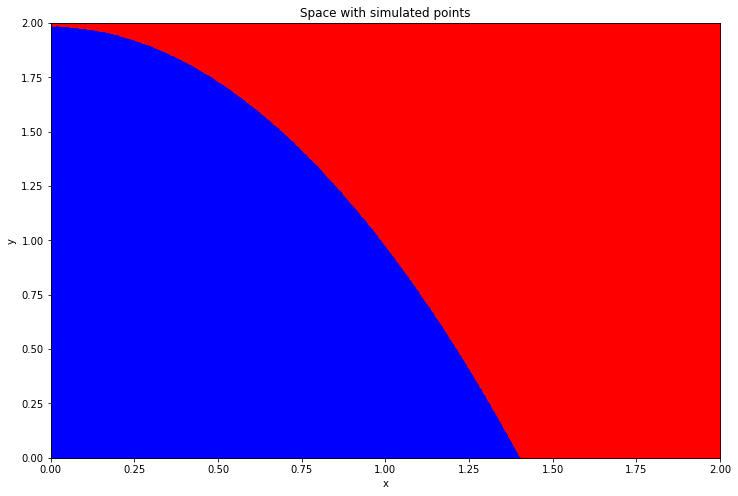

In [ ]:
plt.figure(figsize=(12,8))
plt.ylim(bottom=0, top=2)
plt.xlim(left=0, right=2)
plt.title("Space with simulated points")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(points_inside['x'], points_inside['y'], c='b')
plt.scatter(points_outside['x'], points_outside['y'], c='r')
plt.show()

In [ ]:
%%time
# 100 n points from 1 to 10^6
n_list = np.linspace(1,10**6,100, dtype=np.int32)
error_list = mcmc_sim_sqrt(n_list)

CPU times: user 59 s, sys: 342 ms, total: 59.4 s
Wall time: 59.4 s


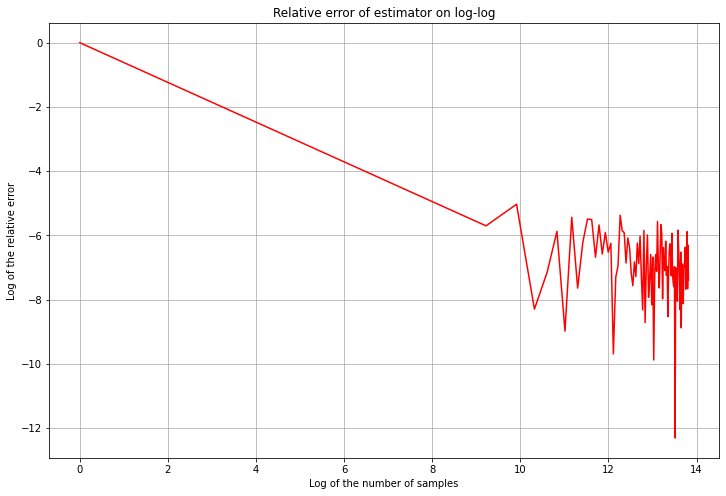

In [ ]:
plt.figure(figsize=(12,8))
x = np.linspace(0,2,50)
plt.xlabel("Log of the number of samples")
plt.ylabel("Log of the relative error")
plt.title("Relative error of estimator on log-log")
plt.plot(np.log(n_list) , np.log(error_list), 'r')
plt.grid()
plt.show()

## Inverse Transform Sampling

In [ ]:
def exp_inv_sampling(n, lmbda):
    """
    Inverse transform sampling
    of exponential distribution

    Parameters
    ----------
    n : int
        Number of samples
    
    lmbda : float
        Exponential parameter lambda

    Returns
    -------
    samples : list
        List of samples 
        
    """
    np.random.seed(1)
    u = np.random.uniform(size=n)
    samples = np.log(u)/(-lmbda)
    return samples


In [ ]:
lmbda = 1 
# 10^6 samples
samples = exp_inv_sampling(10**6, lmbda)

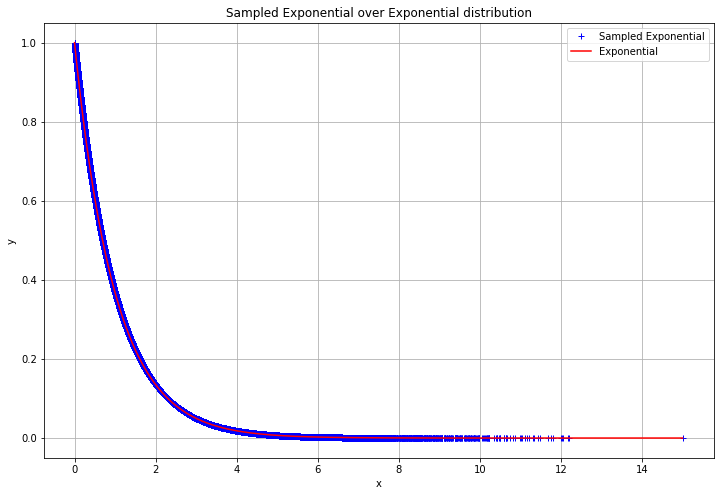

In [ ]:
x = np.linspace(0, 15, 1000)
plt.figure(figsize=(12,8))
plt.title('Sampled Exponential over Exponential distribution')
plt.ylabel('y')
plt.xlabel('x')
plt.plot(samples , expon.pdf(samples), 'b+', label='Sampled Exponential')
plt.plot(x , expon.pdf(x), 'r', label='Exponential')
plt.grid()
plt.legend()
plt.show()

In [ ]:
def par_inv_sampling(n, x0, alpha):
    """
    Inverse transform sampling
    of pareto distribution

    Parameters
    ----------
    n : int
        Number of samples
    
    x0 : float
        Pareto parameter x0
    
    alpha: float
        Pareto parameter alpha
    Returns
    -------
    samples : list
        List of samples 
        
    """
    np.random.seed(1)
    u = np.random.uniform(size=n)
    samples = x0/(u**(1/alpha))
    return samples


In [ ]:
x0 = 1
alpha = 3
# 10^6 samples
samples = par_inv_sampling(10**6, x0, alpha)

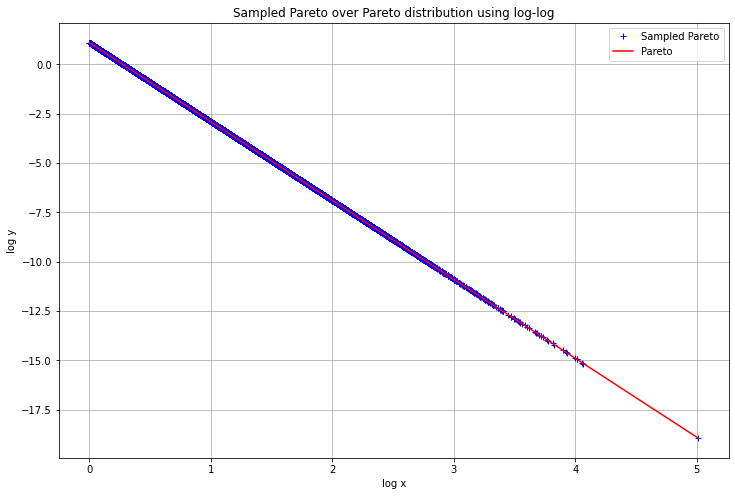

In [ ]:
x = np.linspace(1, 150, 1000)
plt.figure(figsize=(12,8))
plt.title('Sampled Pareto over Pareto distribution using log-log')
plt.ylabel('log y')
plt.xlabel('log x')
plt.plot(np.log(samples), np.log(pareto.pdf(samples, b=alpha)), 'b+', label='Sampled Pareto')
plt.plot(np.log(x) , np.log(pareto.pdf(x, b=alpha)), 'r', label='Pareto')
plt.grid()
plt.legend()
plt.show()

## Monte Carlo to count Web Domains

In [ ]:
def g(url):
    """
    Indicator function to find
    if the domain exists
    """
    try:
        req = requests.get(url, verify=False)
        if req.status_code==200:
            print(f'Valid url found: {url}')
            return 1
        return 0
    except requests.ConnectionError:
        return 0  
    

In [ ]:
def mc_sim_ufrj(k, n_list):
    """
    Monte Carlo method to find 
    the number of UFRJ valid 
    domains using only words
    with length <= k and only
    letters.

    Parameters
    ----------
    k: int
        Max Length of the words
    
    n_list: list
        List of each number of samples

    Return
    -------
    j_list: list
        List with the number of domains
        found in each number of samples
    """
    np.random.seed(1)
    #List of letters
    letter_list = list(string.ascii_lowercase)
    size_s_k = 0
    for i in range(k):
        # Number of possible domains
        # 26^k + 26^k-1 + ... + 26^2 + 26^1
        size_s_k += 26**(i+1)

    j_list = []
    for n in tqdm(n_list):
        g_list = []
        for i in range(n):
            # Uniform to find k less or equal of k
            length_k = int(np.random.uniform(1,k+1))
            letter_number = np.random.uniform(0,26,length_k).astype(np.int32)
            word = ''.join(letter_list[l] for l in letter_number)
            url = f'http://www.{word}.ufrj.br/'
            result = g(url)
            g_list.append(result)

        m_n = sum(g_list)/n
        j = m_n * size_s_k
        j_list.append(j)

    return j_list



In [ ]:
%%time
n_list = np.linspace(1,10**4, 10, dtype=np.int32)
j_list = mc_sim_ufrj(4, n_list)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.ch.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.con.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.fe.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.pec.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.fe.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.fe.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.cav.ufrj.br/
Valid url found: http://www.cla.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.cap.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.pdi.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.eco.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.pre.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.fe.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ead.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.csf.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.pu.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ead.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.smt.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.pea.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.ch.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.cap.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.pu.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.nce.ufrj.br/
Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.csf.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.eco.ufrj.br/
Valid url found: http://www.ppe.ufrj.br/
Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.ch.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.ch.ufrj.br/
Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.pu.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.ch.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.pdi.ufrj.br/
Valid url found: http://www.dme.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.nce.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.fe.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.pec.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.fe.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.lin.ufrj.br/
Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.pu.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.im.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.ch.ufrj.br/
Valid url found: http://www.eei.ufrj.br/
Valid url found: http://www.fnm.ufrj.br/
Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.pu.ufrj.br/
Valid url found: http://www.ch.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.oec.ufrj.br/
Valid url found: http://www.fe.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.cva.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ch.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.pu.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ava.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.dri.ufrj.br/
Valid url found: http://www.ch.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.pu.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/
Valid url found: http://www.eq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ccs.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.im.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.ch.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.pu.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.lam.ufrj.br/
Valid url found: http://www.ru.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ru.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.eq.ufrj.br/
Valid url found: http://www.fe.ufrj.br/
Valid url found: http://www.me.ufrj.br/
Valid url found: http://www.ch.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.if.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.dri.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.iq.ufrj.br/
Valid url found: http://www.me.ufrj.br/


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Valid url found: http://www.ov.ufrj.br/

CPU times: user 1min 25s, sys: 11.1 s, total: 1min 36s
Wall time: 1h 34min 45s


In [ ]:
# add 1 to 0 to make log(1) = 0
j_list[0] = 1

In [ ]:
j_list

[1,
 3419.0935251798564,
 1710.3157894736842,
 2280.7630473905215,
 2672.9696287964002,
 2993.8606911447087,
 1782.1133943302834,
 1894.172537927488,
 1871.2892338845763,
 2376.27]

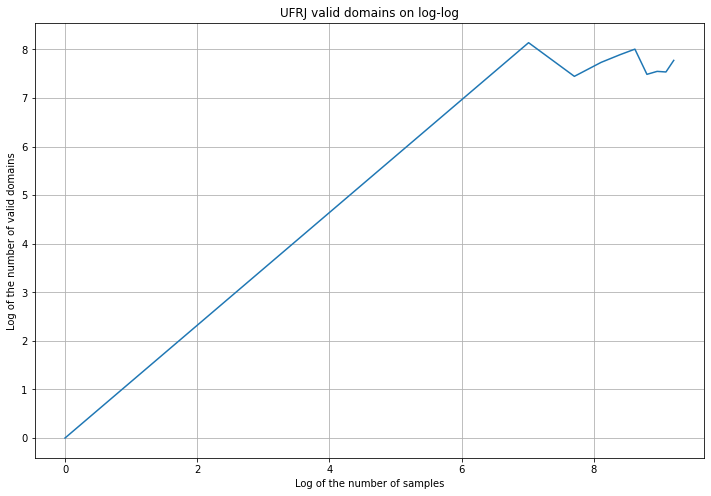

In [ ]:
plt.figure(figsize=(12,8))
plt.title("UFRJ valid domains on log-log")
plt.ylabel("Log of the number of valid domains")
plt.xlabel("Log of the number of samples")
plt.plot(np.log(n_list),np.log(j_list))
plt.grid()
plt.show()

## Rejection Sampling

In [ ]:
def q_Z(z):
    """
    Normal distribution function

    Parameters
    ----------
    z : float
        Random sample

    Returns
    -------
     y: float
        Normal value on z

    """
    y = (1/(np.sqrt(2*np.pi))*np.e**((-z**2)/2))
    return y

In [ ]:
def p_Z(z):
    """
    Uniform distribution on 1
    (what is uniform is the choice
    of z, the value of the function
    is 1)

    Parameters
    ----------
    z : float
        Random sample

    Returns
    -------
    z/z : float
        Return 1 with the dimension
        of the variable z

    """
    # to return 1
    return z/z


In [ ]:
def Z(a,b):
    """
    Distribution used to generate z
    here i use a uniform distribution

    Parameters
    -------
    a : int
        Lower limit for uniform of z
    b : int
        Upper limit for uniform of z
    
    Returns
    -------
    z : float
        Random sample

    """
    z = np.random.uniform(a,b)
    return z

In [ ]:
def rejection_sampling(n, a, b, c):
    """
    Perform rejection sampling
    to sample from a hard to sample
    distribution q_z using a simple
    uniform distribution of z 
    defined on 1.

    Parameters
    ----------
    n : int
        Number of samples
    a : int
        Lower limit for uniform of z
    b : int
        Upper limit for uniform of z
    c : float
        constant that is used to envelope q
    
    Returns
    -------
    samples : list
        List of samples

    """
    np.random.seed(1)
    samples = []
    # half of the samples are positive
    for i in range(int(n/2)):
        no_sample = False
        while not no_sample:
            z = Z(a, b)
            u = np.random.uniform(0, c*p_Z(z))
            no_sample = u < q_Z(z) 
        samples.append(z)
    # half of the samples are negative
    # work for symetric q_Z
    negative_samples = [-i for i in samples]
    samples.extend(negative_samples)
    return samples

In [ ]:
    # Normal max value on mean, mean=0
    c = q_Z(0)
    print(f"c: {c}")

c: 0.3989422804014327


In [ ]:
# Retrieving 100 samples
samples = rejection_sampling(100, 0, 3, c)
samples.sort()

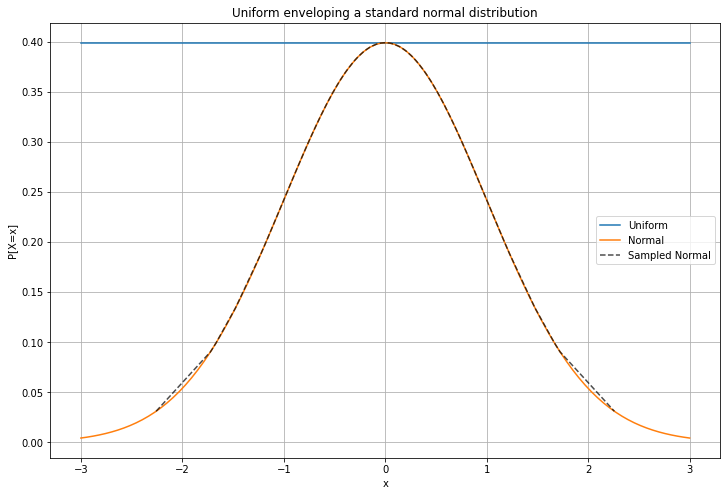

In [ ]:
x = np.linspace(-3,3,100)
plt.figure(figsize=(12,8))
plt.title('Uniform enveloping a standard normal distribution')
plt.ylabel('P[X=x]')
plt.xlabel('x')
plt.plot(x, p_Z(x)*c, label='Uniform')
plt.plot(x, q_Z(x), label='Normal')
samples = np.array(samples)
plt.plot(samples, q_Z(samples), 'k--', label='Sampled Normal', alpha=0.7)
plt.legend()
plt.grid()
plt.show()

In [ ]:
def Z(a,b):
    """
    Here i use an Exponential
    distribution to find z

    a,b parameters are here for 
    compatibility

    We don't need them since we
    are sampling from 0 to inf

    Returns
    -------
     z: float
        Random value with exponential
        probability from 0 to inf

    """
    z = np.random.exponential()
    return z

In [ ]:
def p_Z(z):
    """
    Exponential distribution to envelope
    the Normal distribution using z

    Parameters
    ----------
    z : float
        Random sample

    Returns
    -------
     y: float
        Exponential value on z

    """
    y = expon.pdf(z)
    return y

In [ ]:
c = 1
# Retrieving 10**6 samples using exponential
samples = rejection_sampling(10**6, 1, 1, c)
samples.sort()

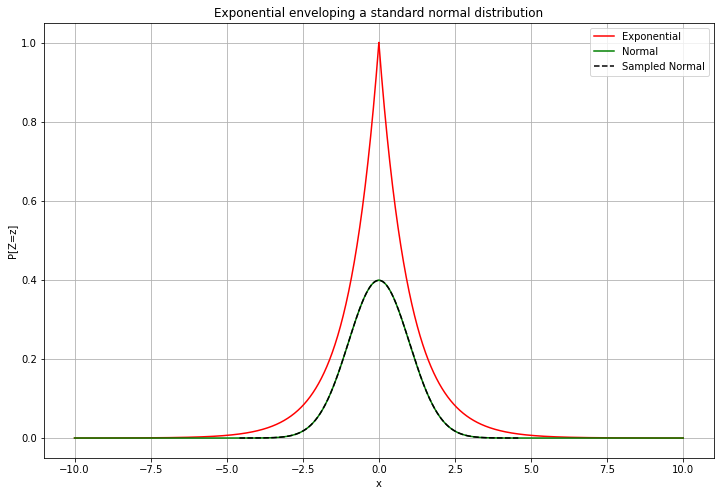

In [ ]:
x = np.linspace(0,10,1000)
plt.figure(figsize=(12,8))
plt.title('Exponential enveloping a standard normal distribution')
plt.ylabel('P[Z=z]')
plt.xlabel('x')
plt.plot(x, p_Z(x), c='r', label='Exponential')
plt.plot(-x, p_Z(x), c='r')
plt.plot(x, q_Z(x), c='g', label="Normal")
plt.plot(-x, q_Z(x), c='g')
samples = np.array(samples)
plt.plot(samples, q_Z(samples), 'k--', label='Sampled Normal')
plt.grid()
plt.legend()
plt.show()

## Importance Sampling

In [ ]:
def g(i):
    """
    Function to sample
    """
    return i*np.log(i)

def h(i,k):
    """
    Distribution proportional to i
    """
    return i/k

def second_moment(N):
    """
    Second moment of estimator
    based on importance sampling

    Parameters
    ----------
    N : int
        Size of the summatory
    
    Returns
    -------
    second_moment : float
        The second moment of 
        estimator using N

    """
    second_moment = 0
    k = (N*(N-1))/2
    for i in range(1,N+1):
        second_moment += (g(i)**2)/h(i,k)
    return second_moment

In [ ]:
second_moment(10**6)

4.438820868365481e+25

In [ ]:
def importance_sampling(N, list_samples):
    """
    Monte Carlo Method used to sample 
    giving different importance to
    each data on the sample space
    this is used to try to reduce 
    the variance of the estimator

    Parameters
    ----------
    N : int
        Size of the summatory
    
    list_samples: list
        List of the number of samples

    Returns
    -------
    error_list: list
        List of relative error of 
        the estimator
    """
    k = (N*(N-1))/2
    all_i = np.arange(1, N)
    g_n = np.sum(g(all_i))
    error_list = []
    for number_samples in list_samples:
        np.random.seed(1)
        sampled_i = np.random.choice(all_i, p=h(all_i,k), size=number_samples)
        g_hat = np.sum(g(sampled_i)/h(sampled_i,k))/number_samples
        rel_error = abs(g_hat - g_n)/g_n
        error_list.append(rel_error)
    return error_list

In [ ]:
%%time
# 10 points from 1 to 10**7
n_list = np.linspace(1, 10**7, 100, dtype=np.int32)
error_list = importance_sampling(10**6, n_list)

CPU times: user 2min 58s, sys: 212 ms, total: 2min 58s
Wall time: 2min 58s


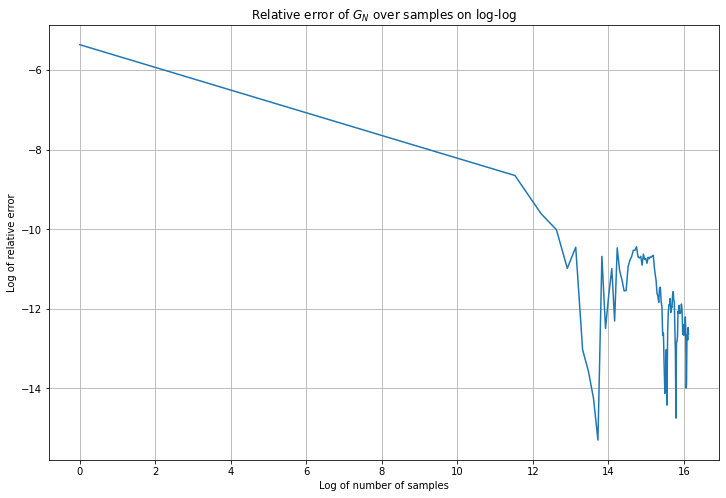

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Relative error of $G_N$ over samples on log-log")
plt.ylabel("Log of relative error")
plt.xlabel("Log of number of samples")
plt.plot(np.log(n_list), np.log(error_list))
plt.grid()
plt.show()

## Monte carlo Integration

In [ ]:
def f(x, alpha):
    """
    f(x) = x^alpha
    """
    return x**alpha

In [ ]:
def monte_carlo_integration(alpha, a, b, n_list):
    """
    Perform monte carlo algorithm to find
    integration of x^alpha from a to b.

    Parameters
    ----------
    alpha : float
        Power of x
    a : float
        Lower bound of integration
    b : float
        Upper bound of integration
    n_list : list
        List of number of samples
    
    Returns
    -------
    g_hat : float
        Simulated integration value
    
    g : float
        Numerically solved integral
    
    relative_error_list : list
        Relative error list between 
        g_hat and g

    """
    np.random.seed(1)
    relative_error_list = []
    for n in n_list:
        x = np.random.uniform(low=a,high=b,size=(n))
        M_n = f(x, alpha).sum()/n
        g_hat = (b-a)*M_n
        g = integrate(f,a,b,args=alpha)[0]
        relative_error = abs(g_hat - g)/g
        relative_error_list.append(relative_error)


    return g_hat,g,relative_error_list
    

In [ ]:
monte_carlo_integration(1,0,1,[10**5])

(0.49921911340158587, 0.5, [0.0015617731968282644])

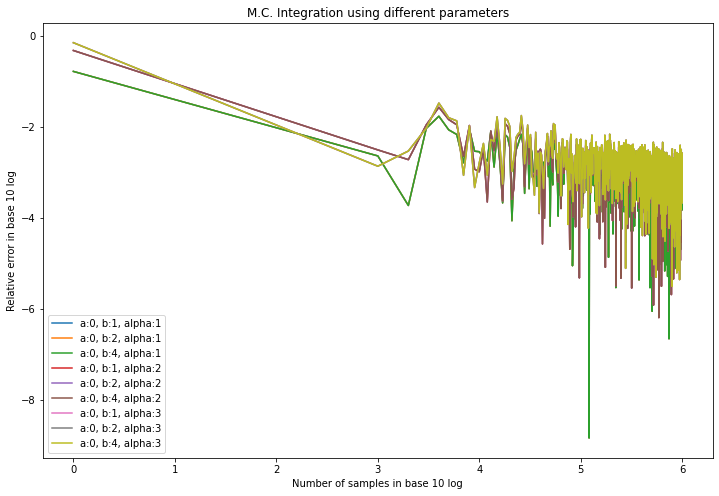

CPU times: user 2min 33s, sys: 990 ms, total: 2min 34s
Wall time: 2min 34s


In [ ]:
%%time
# 1000 points between 1 and 10^6
n_list = np.linspace(1, 10**6, num=1000, dtype=np.int32)
a = 0
b_list = [1,2,4]
alpha_list = [1,2,3]

plt.figure(figsize=(12,8))
plt.title('M.C. Integration using different parameters')
plt.ylabel('Relative error in base 10 log')
plt.xlabel('Number of samples in base 10 log')
for alpha in alpha_list:
    for b in b_list:
        _,_,error_list = monte_carlo_integration(alpha,a,b, n_list)
        # plot each error of combination of parameters
        # log-log plot using base 10
        plt.plot(np.log10(n_list),                
                np.log10(error_list),
                label=f'a:{str(a)}, b:{str(b)}, alpha:{str(alpha)}')
plt.legend()
plt.show()



## Random Permutation Sampling

In [ ]:
def random_permutation(n, k_list):
    """
    Perform random permutation using
    Knuth shuffle algoritm.

    Parameters
    ----------
    n : int
        Number of objects.
    k_list : list
        List of k, k is the 
        number of selected
        objects.
    
    Returns
    -------
    time_list : list
        List of average time elapsed
        during rounds using each k.
    """
    # number of rounds
    num_rounds = 10**3
    time_list = []
    elapsed_time = 0
    # Create a vector to permute
    original_vector = np.arange(n, dtype=np.int32)
    inner_original_vector = original_vector.copy()
    for k in tqdm(k_list):
        for r in range(num_rounds):
            start_time = time.time()
            permutation_vector = []
            # Select k objects
            for i in range(k):
                index = int(np.random.uniform(0,n-i))
                selected_element = inner_original_vector[index]
                # change with last position not used
                inner_original_vector[index] = inner_original_vector[-1-i]
                # set last position with selected element
                inner_original_vector[-1-i] = selected_element
                permutation_vector.append(selected_element)
            finish_time = time.time()
            elapsed_time += (finish_time - start_time)

        mean_elapsed_time = elapsed_time/num_rounds
        time_list.append(mean_elapsed_time)
    
    return time_list

In [ ]:
n_list = [10**4, 10**6, 10**8]
k_list = [10, 10**2, 10**3, 10**4]

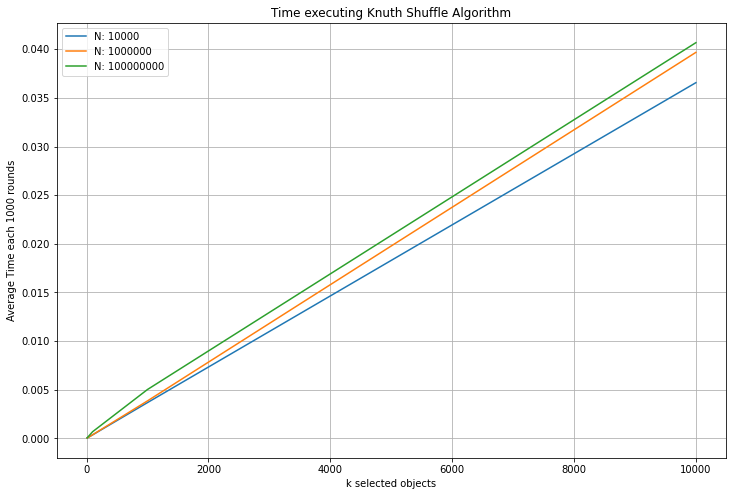

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Time executing Knuth Shuffle Algorithm')
plt.ylabel('Average Time each 1000 rounds')
plt.xlabel('k selected objects')
for n in n_list:
    time_list = random_permutation(n, k_list)
    plt.plot(k_list,time_list, label=f'N: {n}')
plt.grid()
plt.legend()
plt.show()